In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from itertools import product
from scipy.linalg import hadamard

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input

from matplotlib import pyplot as plt
import seaborn as sns

Helper functions

In [2]:
def bool_comb_mat(n_bits=3):
    """Generate all possible combinations of n_bits bits
    as a numpy matrix.
    :param n_bits: (int) Number of bits
    :return: (np.ndarray) All combinations of n_bits
    """
    x = list(product([0, 1], repeat=n_bits))
    return np.array(x)


def walsh_hadamard_sparsity(bool_model, n_bits):
    """Sum the absolute value of all coefficients in the
    Walsh-Hadamard spectrum of the bool_model.
    In other words, determine how sparse (or not) the
    implicit interaction terms are, as represented by the model.
    :param bool_model: (boolean model) Model with predict() method
                        that accepts boolean inputs and outputs
                        tensorflow probability distribution.
    :param n_bits: (int) Number of boolean bits in input
    :return: (int) Number of non-zero coefficients in WH spectrum
    """
    # Generate predictions for all possible combinations of
    # input features
    all_comb = tf.convert_to_tensor(bool_comb_mat(n_bits))
    y_all = tf.squeeze(bool_model(all_comb))

    # Walsh-Hadamard transform (without normalizing constant)
    had_mat = tf.convert_to_tensor(
        hadamard(2**n_dims),
        dtype=tf.float32
    )
    wh_t = tf.linalg.matvec(had_mat, y_all)

    # Sum absolute value of coefficients (L1)
    non_zero_coeff = tf.reduce_sum(
        tf.cast(
            tf.abs(wh_t),
            dtype=tf.float64
        )
    )
    return non_zero_coeff


def mse_loss(y_true, y_pred):
    """Mean Squared Error loss"""
    return tf.reduce_mean(tf.math.squared_difference(y_pred, y_true))


def mse_whs_loss(bool_model, x_batch, y_batch, wh_weight=0.01):
    """Calculate the loss by combining Mean Squared Error (MSE)
    and Walsh-Hadamard sparsity.
    :param bool_model: (tf.keras.Model) Model with predict() method
                        that accepts boolean inputs and outputs
                        tensorflow probability distribution.
    :param x_batch: Batch of boolean features for model input
    :param y_batch: Corresponding y values for input features
    :param wh_weight: (float) Weight applied to WH Sparsity
                      (relative to MSE weight of 1)
    :return: (float) Loss value
    """
    # Assume the last dimension is the number of bits
    n_bits = x_batch.shape[-1]

    # Calculate MSE
    y_pred = tf.squeeze(bool_model(x_batch))
    mse = mse_loss(y_batch, y_pred)

    # Calculate WHS
    whs = walsh_hadamard_sparsity(bool_model, n_bits)
    loss_sum = tf.add(
        tf.cast(mse, dtype=tf.float32),
        tf.cast(wh_weight * whs, dtype=tf.float32)
    )
    return loss_sum


def get_vanilla_dnn(input_shape,
                    num_nodes = [64, 48, 32, 16],
                    l2_reg=False):
    """Return a deep neural net with layers and nodes
    defined by num_nodes. Initialize weights with GlorotUniform (AKA Xavier).
    The final layer is a linear-activated single value.
    :param input_shape: (tuple) Shape of input examples (w/o batch size)
    :param num_nodes: (list) List of integers defining the number of nodes
                      in each layer
    :param l2_reg: (bool) If True, use L2 regularization to constrain Dense layers
    :return: Tensorflow model as returned by Sequential()
    """
    xavier_init = tf.keras.initializers.GlorotUniform()
    layers = [
        Input(shape=input_shape),
        Flatten()
    ]
    # Add one Dense() layer for each value in "num_nodes"
    for nodes in num_nodes:
        kreg = None
        if l2_reg:
            kreg='l2'
        tmp_layer = Dense(
            units=nodes,
            activation='relu',
            kernel_initializer=xavier_init,
            kernel_regularizer=kreg
        )
        layers.append(tmp_layer)

    # The last layer outputs a single fitness value
    layers.extend([
        Dense(units=1,
              activation='linear',
              kernel_initializer=xavier_init)
    ])

    model = Sequential(layers)
    return model


def plot_and_correlate(model, x_data, y_data):
    """Report correlations and visualize as scatter plot.
    :param model: (tf.keras.Model) Trained model
    :param x_data: (np.ndarray or tf.Tensor) X values
    :param y_data: (np.ndarray or tf.Tensor) Corresponding y values
    :return: (matplotlib axis, float)
    """
    y_pred = model(x_data)
    pears = pearsonr(y_pred, y_data)
    print(f'Pearson r {pears[0]:.3f}')
    ax = sns.scatterplot(
        x=y_pred,
        y=y_data
    );
    ax.set_xlabel('model prediction')
    ax.set_ylabel('Ground truth')
    return ax, pears[0]

Create toy data sets

For comparison, one very sparse and one more dense.

In [3]:
# Both functions expect dimension 6 or greater
sparse_fun = lambda x: 2*x[0]*x[3] - 2*x[2] + 2*x[0]*x[1]*x[4] \
                     + 2*x[0]*x[2]*x[3]*x[5]
dense_fun = lambda x: 2*x[0]*x[3] - 2*x[2] + 2*x[0]*x[1]*x[4] \
                    + 2*x[0]*x[2]*x[3]*x[5] \
                   -  2*x[1]*x[3] - 2*x[5] + 2*x[3]*x[1]*x[5] \
                   +  2*x[0]*x[4] - 2*x[0] + 2*x[3]*x[4]*x[5] \
                   -  2*x[2]*x[5] + 2*x[1] - 2*x[2]*x[3]*x[4]
n_dims = 6
# Generate all possible Boolean combinations of dimension n_dims
X = bool_comb_mat(n_dims)
# Apply sparse and dense functions to produce fitness values
y_sparse = np.apply_along_axis(sparse_fun, 1, X)
y_dense = np.apply_along_axis(dense_fun, 1, X)
# Combine into a dictionary
y_dict = {'sparse':y_sparse, 'dense':y_dense}
print(X.shape, y_sparse.shape)


def get_data_split(test_fraction=0.5, y_function='sparse', random_state=30):
    """Return data that has been split and shuffled.
    :param test_fraction: (float) Fraction of data set used for testing (1 - training)
    :param y_function: (str) sparse or dense
    :param random_state: (int) Randomize shuffle and split
    :return: Training and test dataset objects
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_dict[y_function],
        test_size=0.75,
        shuffle=True,
        random_state=random_state
    )
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(6)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(6)
    return train_dataset, test_dataset

(64, 6) (64,)


Define a custom training loop

In [4]:
def run_test_iteration(
    model,
    train_data, test_data,
    optimizer,
    epochs,
    loss_function='mse', wh_weight=1e-4
    ):
    """Train and evaluate a model. Return pearson correlation coefficience
    and Sparsity metric.
    """
    # Train
    for epoch in range(epochs):
        for step, (x_batch_train, y_batch_train) in enumerate(train_data):
            with tf.GradientTape() as tape:
                y_batch_pred = model(x_batch_train, training=True)
                if loss_function == 'mse':
                    loss_value = mse_loss(
                        tf.cast(y_batch_train, dtype=tf.float32),
                        y_batch_pred
                    )
                else:
                    loss_value = mse_whs_loss(
                        model,
                        x_batch_train,
                        tf.cast(y_batch_train, dtype=tf.float32),
                        wh_weight=wh_weight
                    )
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Evaluate
    test_y = np.concatenate([yt for _, yt in test_data], axis=0)
    test_x = np.concatenate([xt for xt, _ in test_data], axis=0)
    y_pred = tf.squeeze(model(test_x)).numpy()
    pears = pearsonr(y_pred, test_y)
    wh_sparsity = walsh_hadamard_sparsity(model, n_dims).numpy()
    return pears[0], wh_sparsity

Run experiment to compare regularization methods on sparse and dense landscapes

- `wh_reg` refers to the addition of a WH transform sparsity term to the loss function (Epistatic Net)
- `l2` refers to L2 regularization on DNN layers
- `no_reg` refers to a DNN without regularization

Each iteration, a random model is initialized, and a random 25% subset of data is used for training, with the remaining 75% used for testing. Model performance is quantified using Pearson and WH sparsity.

In [5]:
landscapes = ['sparse', 'dense']
epochs = 50
reps = 10
model_types = [
    ('wh_reg', 0.03),
    ('no_reg', None),
    ('l2', None)
]
train_frac = [0.25]
learning_rate = 1e-3

results = {
    'model_type_str':[],
    'model_type':[],
    'wh_weight':[],
    'landscape_type':[],
    'train_frac':[],
    'rep':[],
    'metric':[],
    'value':[]
}

for landscape in landscapes:
    print('Landscape', landscape)
    for model_type, wh_weight in model_types:
        # Format model name
        model_type_str = model_type
        if model_type == 'wh_reg':
            model_type_str = f'{model_type}_{wh_weight:.1E}'
        print('model_type', model_type_str)
        for rep in tqdm(range(reps)):
            # Get data
            train_dataset, test_dataset = get_data_split(
                test_fraction=1-train_frac[0],
                y_function=landscape,
                random_state=rep*5
            )
            # Set up optimizer
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            # Set up model and loss function
            loss_function = 'mse'
            if model_type == 'l2':
                model = get_vanilla_dnn(X.shape[1:], l2_reg=True)
            else:
                model = get_vanilla_dnn(X.shape[1:])
                if model_type == 'wh_reg':
                    loss_function = 'wh_reg'

            # Train and evaluate
            metric_names = ['pearson', 'wh_sparsity']
            values = run_test_iteration(
                model,
                train_dataset, test_dataset,
                optimizer,
                epochs,
                loss_function=loss_function,
                wh_weight=wh_weight
            )
            # Record results
            for i, metric in enumerate(metric_names):
                results['model_type_str'].append(model_type_str)
                results['model_type'].append(model_type)
                results['wh_weight'].append(wh_weight)
                results['landscape_type'].append(landscape)
                results['train_frac'].append(train_frac[0])
                results['rep'].append(rep)
                results['metric'].append(metric)
                results['value'].append(values[i])

results_df = pd.DataFrame(results)

Landscape sparse
model_type wh_reg_3.0E-02


100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


model_type no_reg


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


model_type l2


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Landscape dense
model_type wh_reg_3.0E-02


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


model_type no_reg


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


model_type l2


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


Plot results

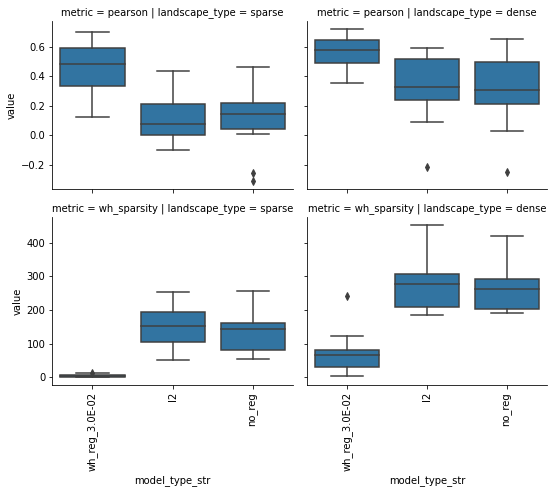

In [6]:
g = sns.FacetGrid(results_df, col='landscape_type', row='metric', sharey='row', aspect=1.3)
plot = g.map(
    sns.boxplot,
    'model_type_str',
    'value',
    order=['wh_reg_3.0E-02', 'l2', 'no_reg']
)
plt.xticks(rotation=45)
for axes in plot.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

In [7]:
for metric in results_df.metric.unique().tolist():
    print('METRIC:', metric)
    metric_df = (
        results_df
        .query(f'metric == "{metric}"')
        .groupby(['landscape_type', 'model_type_str'])
        .value
        .agg([np.mean, np.median])
        .reset_index()
    )
    
    print(metric_df.sort_values(['landscape_type', 'median'], ascending=[0, 1]))

METRIC: pearson
  landscape_type  model_type_str      mean    median
3         sparse              l2  0.119627  0.076179
4         sparse          no_reg  0.105228  0.142918
5         sparse  wh_reg_3.0E-02  0.451511  0.487549
1          dense          no_reg  0.295399  0.305797
0          dense              l2  0.322404  0.328016
2          dense  wh_reg_3.0E-02  0.564101  0.580192
METRIC: wh_sparsity
  landscape_type  model_type_str        mean      median
5         sparse  wh_reg_3.0E-02    5.980916    5.140983
4         sparse          no_reg  136.987729  144.604219
3         sparse              l2  146.357476  151.610326
2          dense  wh_reg_3.0E-02   74.898558   65.399155
1          dense          no_reg  268.310568  261.453391
0          dense              l2  276.375731  277.239667
